# Testing Algorithum

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels SALib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.4 MB/s eta 0:00:00


# Optimization problem

## 1. Define the optimization problem

### State, policy, noise
- State at step k: position $x_k \in \mathbb{R}^2$, heading $\theta_k$, and distance $d_k = |x_k - x_{\text{home}}|$.
- Sensing: RSSI samples $R_k$ produced by a path-loss model + shadowing noise.
The filtered estimate $\hat{R}_k$ comes from the median + EMA filters.
- Policy: The algorithm maps $(\hat{R}k, \hat{R}{k-1}) \mapsto \theta_{k+1}$
(turn if worse) and computes adaptive step size by exponential decay.
- Randomness: start position (50–500 m radius, random heading),
noise in RSSI, heading, and environment.

### Decision Variables (AlgoParams)
$$ p=(v,\phi,w,\alpha,\lambda,f_s) $$

where:
- $v$ = speed (1–10 m/s)
- $\phi$ = turn angle (60°–90°)
- $w$ = median filter window (5–20)
- $\alpha$ = EMA smoothing factor (0.0–1.0)
- $\lambda$ = decay rate (1–10)
- $f_s$ = RSSI sampling rate (1–10 Hz)

### Objectives and Constraints
We want fast and efficient convergence, independent of the environment.
Define convergence when $d_k \le r_{\text{stop}}$ with success indicator $S \in {0, 1}$.

> Main outcomes:
> - Time to converge: $T(\mathbf{p})$
> - Path length: $L(\mathbf{p})$
> - Since time and distance trade off, treat it as a multi-objective problem over
$(\mathbb{E}[T], \mathbb{E}[L])$.

To make results comparable:

$$ T^* = \frac{T}{d_0/v} $$
$$ L^* = \frac{L}{d_0} $$

where $d_0$ is the initial distance.
If $T^* \approx 1$ and $L^* \approx 1$, that’s nearly straight-line optimal.

## 2. Proving Independence from Environment (EnvModel)

Can’t prove it analytically, but can demonstrate robustness.

#### 1. Environment Ensemble:

$P_0 \sim \mathcal{U}[-50, -30]$ dBm

$n \sim \mathcal{U}[1.4, 3.0]$

$\sigma(d)$ scaled by $c_\sigma \sim \mathcal{U}[0.5, 2.0]$

#### 2. Invariance Checks:

$P_0$ cancels in the decision rule since only relative RSSI changes matter.
(Formally, $\Delta R = R_k - R_{k-1}$.)

Regress performance metrics on $P_0$, $n$, $c_\sigma$ and show near-zero coefficients.

#### 3. Mixed-effects modeling:
Include EnvModel as a random effect and show its variance component is small.

## 3. Experimental Design

#### Factors and Ranges

- Speed ($v$) - 1–10 m/s
- Turn angle ($\phi$) - 60–90°
- Median window ($w$) - 5–20
- EMA alpha ($\alpha$) - 0.0–1.0
- Decay rate ($\lambda$) - 1–10
- Sampling rate ($f_s$) - 1–10 Hz

#### Design Type
- Use Latin Hypercube Sampling (LHS) across 6-D parameter space (200–500 samples).
- For each sample, run $R$ replications (e.g., $R=30$–$50$) with:
> - different random start positions (50–500 m),
> - different EnvModel draws,
> - different random seeds.

#### Outputs
Estimate $\mathbb{E}[T^]$, $\mathbb{E}[L^]$, and variances.
Use 95% confidence intervals to evaluate stability.

## 4. Statistical Analysis

#### Mixed-Effects Modeling

Model each normalized outcome:

$$ Y_{ij}=\beta_0 + \sum_{k}\beta_k p_k + \sum_{k<l}\beta_k p_k p_l +  b_{env,j} +  b_{start,j} + \epsilon_{ij}$$

where:
- $Y \in {T^*, L^*}$
- fixed effects = parameters $(v, \phi, w, \alpha, \lambda, f_s)$
- random intercepts $b_{\text{env},j}$ for EnvModel and $b_{\text{start},j}$ for starting conditions.

Interpretation:
- $\beta_k$ → which parameters matter and how much.
- Variance of $b_{\text{env}}$ → sensitivity to environment (should be small).

#### Global Sensitivity Analysis
Use Sobol’ indices:
- First-order $S_k$: direct effect of each parameter.
- Total $S_k^{\text{tot}}$: effect including interactions.

Large $S_k^{\text{tot}}$ → crucial parameters.
Near-zero → negligible ones.

If computation is heavy, start with Morris screening to rank parameters.

#### Surrogate & Pareto Analysis
- Fit a Gaussian Process or Random Forest surrogate:
  $$p \mapsto (E[T^*], E[L^*])$$
- Extract the Pareto frontier and plot trade-offs between $T^*$ and $L^*$.
- Use Shapley values or permutation importance to visualize parameter influence.

#### Key Statistical Tests
- Turn angle: ANOVA or Tukey HSD between $\phi = 60°$, 75°, 90°.
- Filter latency tradeoff: regress $T^*$ on $w$ and $f_s$; expect large $w$ → more latency.
- EMA role: test $H_0 : \beta_\alpha = 0$.

EMA often has small independent effect if median filter is large.


## 5. Optimization Procedure

- Normalize outcomes ($T^*$, $L^*$).
- Evaluate samples from LHS.
- Build surrogate models for $\mathbb{E}[T^]$, $\mathbb{E}[L^]$.
- Extract Pareto-optimal set $\mathcal{P}$.
- Add robustness evaluation:
    - mean, std, and CVaR₉₀ (conditional value at risk).
    - choose solutions that minimize both mean and dispersion.

Use robust Pareto dominance to select parameter sets that perform well across environments.

Optionally, use Bayesian optimization (e.g., ParEGO, EHI) to refine with fewer simulations.

## 6. Demonstrating Environment Independence

You show independence by:

- Sampling many EnvModels and finding small variance of random effect $b_{\text{env}}$.
- Normalizing by $d_0$ and $v$.
- Showing stable Pareto fronts across EnvModels.
- Using robust Pareto-optimal selection.

This demonstrates the algorithm converges efficiently regardless of the environment

# Optimization

## Setup & Utilities

In [2]:
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels SALib

In [3]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from collections import deque
import math, itertools
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.cm as cm
import seaborn as sns

from scipy.stats import qmc
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import time

In [4]:
# @title
# Plot style
plt.rcParams["figure.figsize"] = (6.5, 4.2)
plt.rcParams["axes.grid"] = True

def cvar(values, alpha=0.10, minimize=True):
    """
    CVaR (Conditional Value at Risk) style tail-average.
    For minimize problems, average of worst (largest) alpha-fraction if minimize=False,
    or largest alpha-fraction if minimize=True? We want the worst tail for "minimize".
    We’ll take the upper tail (largest values) as the "bad" side for minimize.
    """
    v = np.asarray(values)
    if minimize:
        # worst = largest values
        k = max(1, int(math.ceil(alpha * len(v))))
        return np.mean(np.sort(v)[-k:])
    else:
        # for maximize objectives, worst = smallest values
        k = max(1, int(math.ceil(alpha * len(v))))
        return np.mean(np.sort(v)[:k])

In [5]:
# @title
def plot_run(env, sim_out, home=(0.0, 0.0), title="Simulation run"):


    # --- extract & derive ---
    path = np.asarray(sim_out["path"], dtype=float)
    rssi = np.asarray(sim_out.get("rssi", sim_out.get("rssi_trace", [])), dtype=float)
    hx, hy = float(home[0]), float(home[1])

    # distances to home per step (for hover)
    dtrace = np.hypot(path[:,0] - hx, path[:,1] - hy)
    start_d = float(dtrace[0])
    final_d = float(dtrace[-1])

    steps = int(sim_out.get("steps", max(len(path) - 1, 0)))
    T = float(sim_out.get("T", np.nan))
    L = float(sim_out.get("L", np.nan))
    success = sim_out.get("success", None)

    stop_radius = float(env.d0) * (10.0 ** ((env.P0 - env.target_rssi_dbm) / (10.0 * env.n)))
    status = "success" if success is True else ("fail" if success is False else "—")
    subtitle = (
        f"{status} | steps={steps} | time={T:.2f}s | dist={L:.2f} m | "
        f"start d={start_d:.2f} m | final d={final_d:.2f} m"
    )

    # --- figure ---
    fig = make_subplots(
        rows=1, cols=2, column_widths=[0.60, 0.40],
        subplot_titles=[f"Path<br><sup>{subtitle}</sup>", "RSSI over steps"]
    )

    # Path: polyline with small markers
    fig.add_trace(
        go.Scatter(
            x=path[:,0], y=path[:,1],
            mode="lines+markers",
            name="Path",
            line=dict(width=1.2),
            marker=dict(size=5),
            text=[f"d={d:.2f} m" for d in dtrace],
            hovertemplate="x=%{x:.2f} m<br>y=%{y:.2f} m<br>%{text}<extra></extra>"
        ),
        row=1, col=1
    )

    # Start and Home markers
    fig.add_trace(
        go.Scatter(
            x=[path[0,0]], y=[path[0,1]],
            mode="markers+text",
            text=["Start"], textposition="top center",
            marker=dict(size=9, symbol="circle", color="#1f77b4"),
            name="Start"
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=[hx], y=[hy],
            mode="markers+text",
            text=["Home"], textposition="top center",
            marker=dict(size=10, symbol="x", color="#d62728"),
            name="Home"
        ),
        row=1, col=1
    )

    # Optional stop/target radius
    if stop_radius is not None and stop_radius > 0:
        t = np.linspace(0, 2*np.pi, 361)
        fig.add_trace(
            go.Scatter(
                x=hx + stop_radius*np.cos(t),
                y=hy + stop_radius*np.sin(t),
                mode="lines",
                line=dict(dash="dash", width=1),
                name=f"Stop r={stop_radius} m",
                hoverinfo="skip"
            ),
            row=1, col=1
        )

    # Equal aspect for path
    fig.update_xaxes(title_text="X (m)", scaleanchor="y", scaleratio=1, row=1, col=1)
    fig.update_yaxes(title_text="Y (m)", row=1, col=1)

    # RSSI vs step
    if rssi.size == 0:
        rssi = np.full(len(path), np.nan)  # keep plot structure if not recorded
    fig.add_trace(
        go.Scatter(
            x=list(range(len(rssi))),
            y=rssi,
            mode="lines+markers",
            line=dict(width=1.2),
            marker=dict(size=5),
            name="RSSI (dBm)",
            hovertemplate="step=%{x}<br>RSSI=%{y:.2f} dBm<extra></extra>"
        ),
        row=1, col=2
    )
    fig.update_xaxes(title_text="Step", row=1, col=2)
    fig.update_yaxes(title_text="RSSI (dBm)", row=1, col=2)

    fig.update_layout(width=1100, height=520, title_text=title, showlegend=True)
    fig.show()

    # --- print metrics ---
    print("=== Run metrics ===")
    print(f"Direct distance (start → home): {start_d:.2f} m")
    print(f"Steps: {steps}")
    print(f"Total time: {T:.2f} s")
    print(f"Total path length: {L:.2f} m")
    if success is not None:
        print(f"Success: {success} (final distance {final_d:.2f} m)")

In [42]:
def plot_run(env, sim_out, home=(0.0, 0.0), title="Simulation run"):

    # --- extract & derive ---
    path = np.asarray(sim_out["path"], dtype=float)
    rssi = np.asarray(sim_out.get("rssi", sim_out.get("rssi_trace", [])), dtype=float)
    hx, hy = float(home[0]), float(home[1])

    # distances to home per step (for hover)
    dtrace = np.hypot(path[:,0] - hx, path[:,1] - hy)
    start_d = float(dtrace[0])
    final_d = float(dtrace[-1])

    steps = int(sim_out.get("steps", max(len(path) - 1, 0)))
    T = float(sim_out.get("T", np.nan))
    L = float(sim_out.get("L", np.nan))
    success = sim_out.get("success", None)

    stop_radius = float(env.d0) * (10.0 ** ((env.P0 - env.target_rssi_dbm) / (10.0 * env.n)))
    status = "success" if success is True else ("fail" if success is False else "—")
    subtitle = (
        f"{status} | steps={steps} | time={T:.2f}s | dist={L:.2f} m | "
        f"start d={start_d:.2f} m | final d={final_d:.2f} m"
    )

    # --- figure ---
    fig = make_subplots(
        rows=1, cols=2, column_widths=[0.60, 0.40],
        subplot_titles=["Flight Path", "RSSI vs Steps"]
    )

    # MATLAB-like palette
    matlab_blue   = "#0072BD"
    matlab_orange = "#D95319"
    matlab_red    = "#A2142F"
    matlab_green  = "#77AC30"
    matlab_gray   = "#7F7F7F"

    # Path: MATLAB ORANGE
    fig.add_trace(
        go.Scatter(
            x=path[:,0], y=path[:,1],
            mode="lines+markers",
            name="Path",
            line=dict(width=1.5, color=matlab_orange),
            marker=dict(size=4, symbol="circle", color=matlab_orange),
            text=[f"d={d:.2f} m" for d in dtrace],
            hovertemplate="x=%{x:.2f} m<br>y=%{y:.2f} m<br>%{text}<extra></extra>"
        ),
        row=1, col=1
    )

    # Start and Home markers
    fig.add_trace(
        go.Scatter(
            x=[path[0,0]], y=[path[0,1]],
            mode="markers+text",
            text=["Start"], textposition="top center",
            marker=dict(size=9, symbol="circle", color=matlab_green, line=dict(width=1, color="black")),
            name="Start"
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=[hx], y=[hy],
            mode="markers+text",
            text=["Home"], textposition="top center",
            marker=dict(size=10, symbol="x", color=matlab_red),
            name="Home"
        ),
        row=1, col=1
    )

    # Optional stop/target radius (subtle gray dash)
    if stop_radius is not None and stop_radius > 0:
        t = np.linspace(0, 2*np.pi, 361)
        fig.add_trace(
            go.Scatter(
                x=hx + stop_radius*np.cos(t),
                y=hy + stop_radius*np.sin(t),
                mode="lines",
                line=dict(dash="dash", width=1.2, color=matlab_gray),
                name=f"Stop r={stop_radius} m",
                hoverinfo="skip"
            ),
            row=1, col=1
        )

    # Equal aspect for path + dense grids
    fig.update_xaxes(
        title_text="X (m)", scaleanchor="y", scaleratio=1,
        showgrid=True, gridcolor="#E6E6E6", gridwidth=1,
        zeroline=True, zerolinewidth=1,
        tickcolor="#000", ticks="inside", nticks=14,
        row=1, col=1
    )
    fig.update_yaxes(
        title_text="Y (m)",
        showgrid=True, gridcolor="#E6E6E6", gridwidth=1,
        zeroline=True, zerolinewidth=1,
        tickcolor="#000", ticks="inside", nticks=14,
        row=1, col=1
    )

    # RSSI vs step: MATLAB BLUE
    if rssi.size == 0:
        rssi = np.full(len(path), np.nan)
    fig.add_trace(
        go.Scatter(
            x=list(range(len(rssi))),
            y=rssi,
            mode="lines+markers",
            line=dict(width=1.5, color=matlab_blue),
            marker=dict(size=4, symbol="circle", color=matlab_blue),
            name="RSSI (dBm)",
            hovertemplate="step=%{x}<br>RSSI=%{y:.2f} dBm<extra></extra>"
        ),
        row=1, col=2
    )
    fig.update_xaxes(
        title_text="Step",
        showgrid=True, gridcolor="#E6E6E6", gridwidth=1,
        zeroline=True, zerolinewidth=1,
        tickcolor="#000", ticks="inside", nticks=14,
        row=1, col=2
    )
    fig.update_yaxes(
        title_text="RSSI (dBm)",
        showgrid=True, gridcolor="#E6E6E6", gridwidth=1,
        zeroline=True, zerolinewidth=1,
        tickcolor="#000", ticks="inside", nticks=14,
        row=1, col=2
    )

    # Layout: white bg, bigger title, no legend
    big_title = "Simulated Flight Path of UAV's Return-to-Home Maneuver"
    fig.update_layout(
        width=1100, height=580,
        title=dict(text=big_title, x=0.5, xanchor="center", y=0.98),
        showlegend=False,  # remove legend
        paper_bgcolor="white",
        plot_bgcolor="white",
        margin=dict(l=60, r=30, t=70, b=140),
        font=dict(family="DejaVu Sans, Arial, Helvetica, sans-serif", size=12),
    )

    # Readable stats under each subplot (centered, white box)
    ann_style = dict(
        showarrow=False,
        align="center",
        font=dict(size=12),
        bgcolor="rgba(255,255,255,0.95)",
        bordercolor="#CCCCCC",
        borderwidth=1,
        borderpad=4
    )
    fig.add_annotation(text=subtitle, xref="x domain",  yref="paper", x=1.5, y=-0.2, **ann_style)
    # fig.add_annotation(text=subtitle, xref="x2 domain", yref="paper", x=0.5, y=-0.12, **ann_style)

    fig.show()

    # --- print metrics ---
    print("=== Run metrics ===")
    print(f"Direct distance (start → home): {start_d:.2f} m")
    print(f"Steps: {steps}")
    print(f"Total time: {T:.2f} s")
    print(f"Total path length: {L:.2f} m")
    if success is not None:
        print(f"Success: {success} (final distance {final_d:.2f} m)")


## Define the Environment & Algorithm

In [8]:
# @title
@dataclass
class EnvModel:
    P0: float = -40.0     # dBm at 1 m
    n: float  = 1.465     # path-loss exponent
    d0: float = 1.0       # reference distance (m)
    # distance -> RSSI std dev (growing with distance). We'll use a simple curve if no table is provided.
    sigma_min: float = 3.0
    sigma_max: float = 6.0
    sigma_max_dist: float = 100.0  # at ~100 m we hit sigma_max

    target_rssi_dbm: float = -50.0   # "close enough to home"
    rssi_floor_dbm: float  = -100.0  # for scaling step size

    def rssi_mean(self, dist_m):
        d = max(self.d0, float(dist_m))
        return self.P0 - 10.0 * self.n * math.log10(d / self.d0)

    def rssi_sigma(self, dist_m):
        # simple linear ramp from sigma_min at 0–d0 up to sigma_max at ~sigma_max_dist
        t = np.clip(dist_m / self.sigma_max_dist, 0.0, 1.0)
        return self.sigma_min + t * (self.sigma_max - self.sigma_min)

    def sample_rssi(self, dist_m, rng: np.random.Generator):
        mu = self.rssi_mean(dist_m)
        sd = self.rssi_sigma(dist_m)
        return rng.normal(mu, sd)

@dataclass
class AlgoParams:
    speed: float               # m/s (continuous forward velocity magnitude)
    phi_deg: float             # turn angle when "worse", in degrees
    w: int                     # median filter window size (# of quick RSSI samples)
    alpha: float               # EMA smoothing factor [0..1]
    decay_rate: float          # how fast step shrinks as RSSI improves
    fs: float                  # RSSI samples per second (Hz)
    step_size_constant: float  # NEW KNOB: base step size scale (meters per "decision step")
    min_step_size: float = 0.4 # floor for step length (m)


In [37]:
# @title
def simulate_run(
    env: EnvModel,
    params: AlgoParams,
    start_xy=(15.0, -10.0),
    home_xy=(0.0, 0.0),
    heading_rad=None,
    max_steps=5000,
    rng_seed=123,
):
    """
    Simulate the policy:
      - Move forward along current heading by a step
      - Measure filtered RSSI
      - If RSSI got worse than previous filtered value -> rotate heading by phi and continue
      - Step size shrinks as RSSI improves (controlled by step_size_constant & decay_rate)

    Returns dict with path, times, T (sec), L (m), normalized T* and L*, and success flag.
    """
    rng = np.random.default_rng(rng_seed)

    # initial state
    x, y = map(float, start_xy)
    hx, hy = map(float, home_xy)
    if heading_rad is None:
        heading = math.atan2(hy - y, hx - x) - 0.05  # roughly towards home at start
    else:
        heading = float(heading_rad + 8.7)

    # filters
    rssi_window = deque(maxlen=max(1, int(params.w)))
    ema_last = None

    def sense_rssi_filtered(px, py):
        # take w quick samples
        dist = math.hypot(px - hx, py - hy)
        # emulate w samples in ~1 / fs seconds
        samples = [env.sample_rssi(dist, rng) for _ in range(max(1, int(params.w)))]
        median_val = float(np.median(samples))
        # EMA
        nonlocal ema_last
        if ema_last is None:
            ema_last = median_val
        else:
            ema_last = (1.0 - params.alpha) * ema_last + params.alpha * median_val
        return ema_last

    # measure once to initialize
    rssi_prev = sense_rssi_filtered(x, y)

    start_dist = math.hypot(x - hx, y - hy)
    initial_rssi = rssi_prev
    _initial_step_size = start_dist / params.step_size_constant
    rssi_now = initial_rssi
    # time bookkeeping: each decision step includes the RSSI sampling time (w/fs) and movement time (step/speed)
    total_time = 0.0
    total_dist = 0.0

    path = [(x, y)]
    rssi_series = [rssi_prev]
    success = False

    for step in range(int(max_steps)):
        # compute adaptive step size from RSSI (higher RSSI => smaller steps)
        # map RSSI to [0..1] proximity score where 0 ~ far (rssi ~ floor), 1 ~ close (rssi ~ target)
        # prox = np.clip((rssi_prev - env.rssi_floor_dbm) / (env.target_rssi_dbm - env.rssi_floor_dbm), 0.0, 1.0)
        # print(prox)
        progress = abs(rssi_now - initial_rssi) / abs(initial_rssi - env.target_rssi_dbm)

        step_len = max(
            params.min_step_size,
            _initial_step_size * math.exp(-params.decay_rate * min(1.0, max(0.0, progress)))
        )

        # movement: advance along heading
        dx = step_len * math.cos(heading)
        dy = step_len * math.sin(heading)
        x_new, y_new = x + dx, y + dy

        # time spent moving this step
        move_time = step_len / max(1e-6, params.speed)
        # time spent sampling RSSI (take w samples at fs Hz)
        sample_time = max(1, int(params.w)) / max(1e-6, params.fs)
        total_time += move_time + sample_time
        total_dist += math.hypot(dx, dy)

        # sense at new point
        rssi_now = sense_rssi_filtered(x_new, y_new)

        # if RSSI got worse than last filtered value, rotate heading by +phi
        if rssi_now < rssi_prev:
            heading += math.radians(params.phi_deg)

        # update
        x, y = x_new, y_new
        rssi_prev = rssi_now
        path.append((x, y))
        rssi_series.append(rssi_now)

        # stop condition: strong enough signal
        if rssi_now >= env.target_rssi_dbm:
            success = True
            break

    start_dist = math.hypot(start_xy[0] - hx, start_xy[1] - hy)
    T = total_time
    L = total_dist
    T_star = T / max(1e-6, start_dist)
    L_star = L / max(1e-6, start_dist)

    return dict(
        path=np.array(path),
        rssi=np.array(rssi_series),
        T=T, L=L, T_star=T_star, L_star=L_star,
        success=success,
        steps=len(path)-1
    )

In [43]:
# @title
params_test = AlgoParams(
    speed=2.0, phi_deg=86.5, w=8, alpha=0.14,
    decay_rate=4.5, fs=50.0, step_size_constant=5
    )
env = EnvModel(
    P0=-40.0,          # reference RSSI at 1 m (dBm)
    n=2.5,           # path-loss exponent
    target_rssi_dbm=-80.0,  # stopping condition
    rssi_floor_dbm=-100.0   # floor for scaling
)
out = simulate_run(env, params_test, start_xy=(600, -500), rng_seed=42)
plot_run(env, out, home=(0,0), title="Demo run")


=== Run metrics ===
Direct distance (start → home): 781.02 m
Steps: 34
Total time: 489.57 s
Total path length: 968.27 m
Success: True (final distance 22.69 m)


## Define Parameter Ranges, Sample with Latin Hypercube, and Visualize

In [ ]:
# @title

# Parameter ranges (feel free to tweak)
PARAM_RANGES = {
    "speed":              (0.5, 1.0),    # m/s
    "phi_deg":            (60.0, 90.0), # degrees
    "w":                  (3, 15),       # median window (int)
    "alpha":              (0.05, 0.8),   # EMA
    "decay_rate":         (5.0, 10.0),    # step shrink speed
    "fs":                 (1.0, 5.0),   # Hz
    "step_size_constant": (5, 20),    # NEW knob (m)
}

def sample_latin_hypercube(n_samples, ranges, rng_seed=2025):
    keys = list(ranges.keys())
    lows = np.array([ranges[k][0] for k in keys], dtype=float)
    highs= np.array([ranges[k][1] for k in keys], dtype=float)
    sampler = qmc.LatinHypercube(d=len(keys), seed=rng_seed)
    U = sampler.random(n=n_samples)  # in [0,1]^d
    X = qmc.scale(U, lows, highs)
    df = pd.DataFrame(X, columns=keys)

    # cast integers
    df["w"] = df["w"].round().astype(int)
    return df

In [ ]:
# --- run sampling ---
N_DESIGN = 100
design_df = sample_latin_hypercube(N_DESIGN, PARAM_RANGES, rng_seed=2025)
design_df.head()

,speed,phi_deg,w,alpha,decay_rate,fs,step_size_constant
0,2.525249,82.685397,11,0.246221,8.651210,1.276911,5.102382
1,1.628620,84.097239,14,0.639578,7.438489,4.793322,17.876985
2,1.356166,60.772831,11,0.608813,7.835583,4.431535,9.468885
3,1.508944,88.022745,9,0.739176,8.875185,2.268395,8.227122
4,4.237317,74.122047,10,0.674135,9.786105,3.979295,15.079313


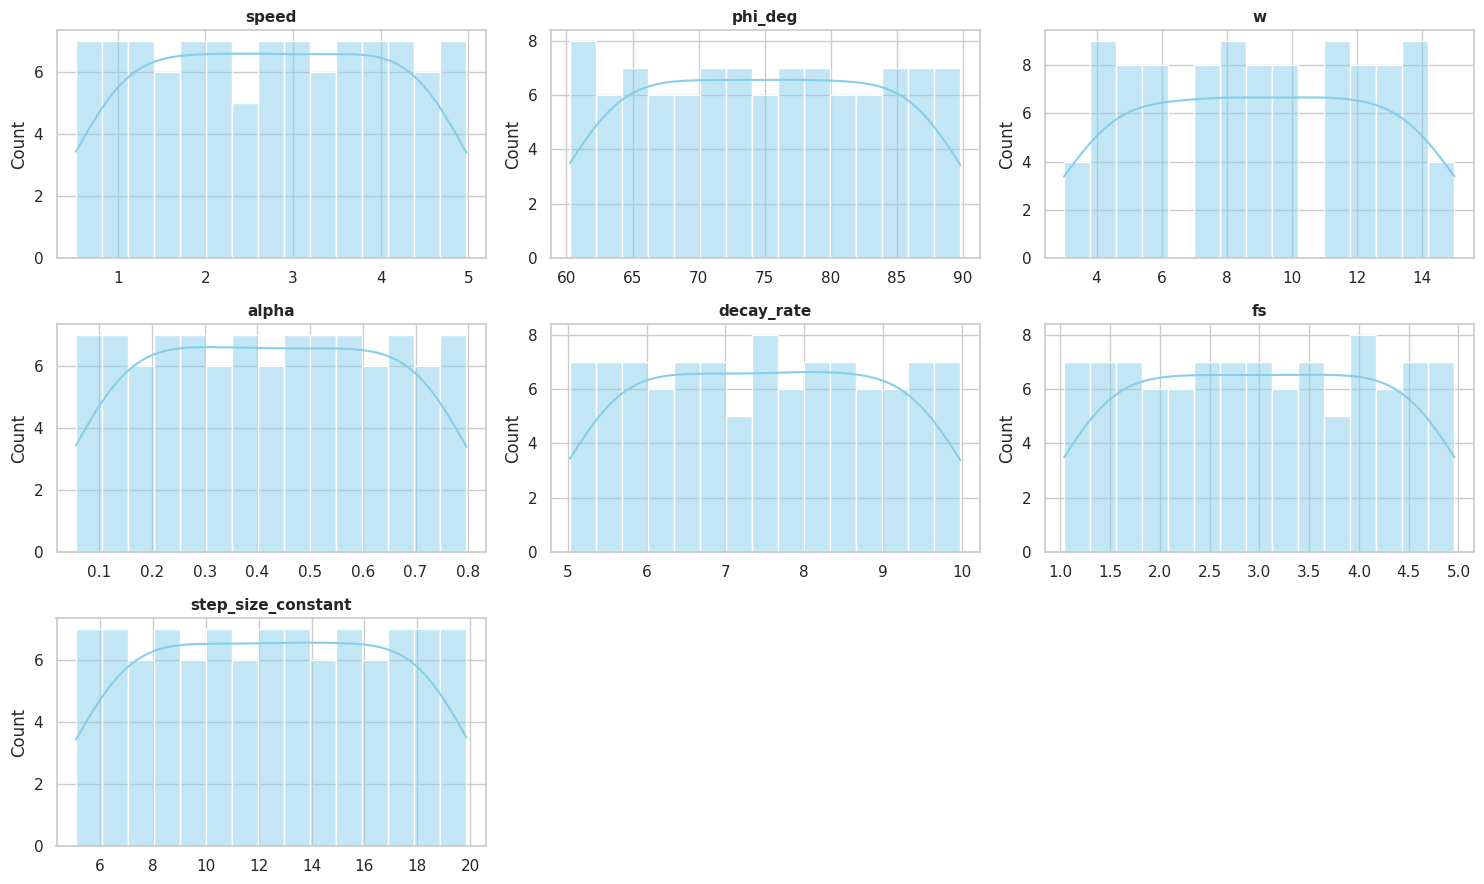

In [ ]:
# @title
sns.set_theme(style="whitegrid")

cols = design_df.columns.tolist()
n = len(cols)
ncols = 3
nrows = int(math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*3))
axes = axes.ravel()

for i, c in enumerate(cols):
    ax = axes[i]
    sns.histplot(design_df[c], bins=15, kde=True, ax=ax, color="skyblue")
    ax.set_title(c, fontsize=11, weight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Count")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

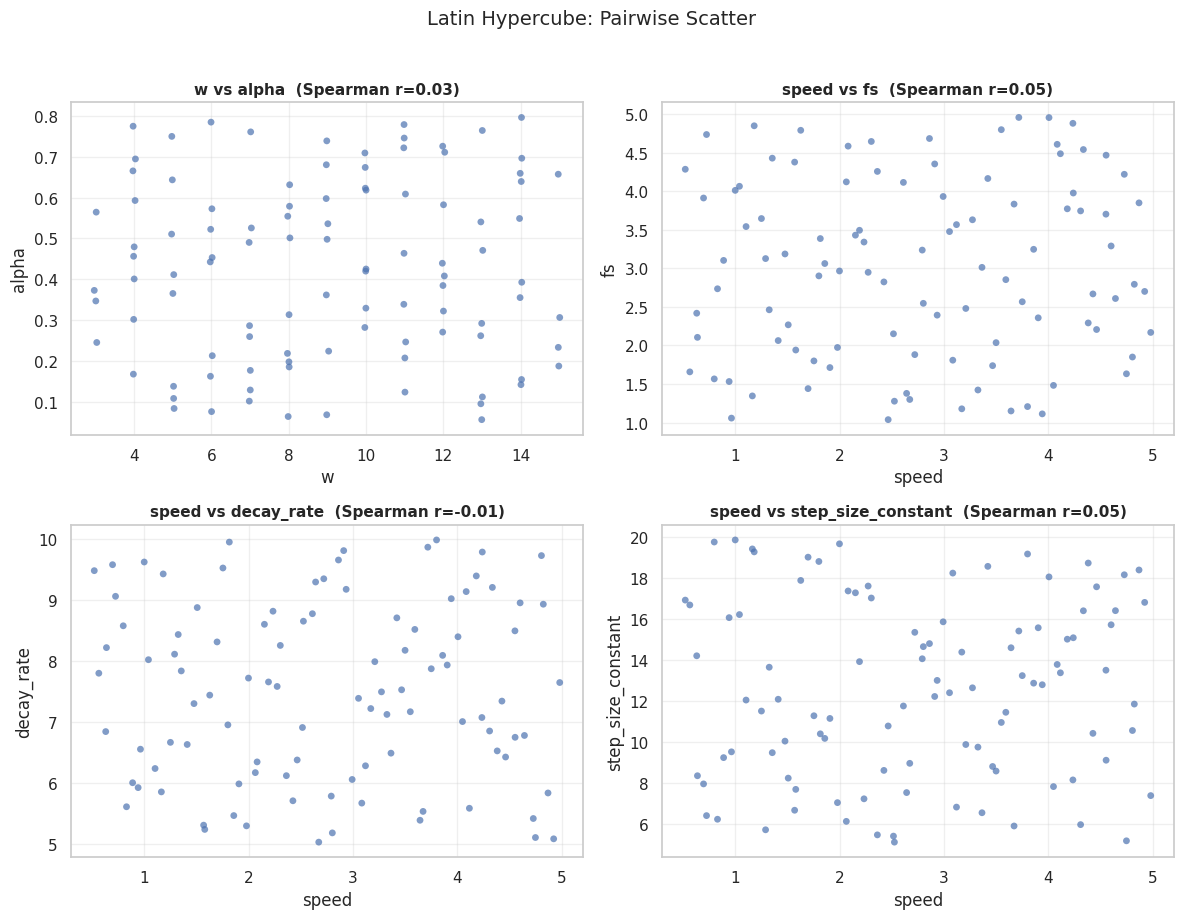

In [ ]:
# @title
pairs = [
    ("w", "alpha"),                 # 1) w vs alpha
    ("speed", "fs"),                # 2) speed vs fs
    ("speed", "decay_rate"),        # 3) speed vs decay_rate
    ("speed", "step_size_constant") # 4) speed vs step_size_constant
    # Add more pairs if you like, e.g. ("phi_deg", "decay_rate")
]

def _needs_jitter(series):
    # Jitter if the data look discrete (like ints) or have few unique values
    return (np.issubdtype(series.dtype, np.integer)) or (series.nunique() < max(12, len(series)*0.05))

def _jitter(arr, scale=0.15):
    # Symmetric uniform jitter proportional to data range
    arr = np.asarray(arr, dtype=float)
    rng = np.nanmax(arr) - np.nanmin(arr)
    if rng == 0:
        rng = 1.0
    return arr + np.random.uniform(-scale, scale, size=len(arr)) * rng * 0.02  # 2% of range

def scatter_pairs(df, pairs, ncols=2, point_size=24, alpha=0.7, seed=7):
    rng = np.random.default_rng(seed)
    n = len(pairs)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4.5*nrows), squeeze=False)
    axes = axes.ravel()

    for i, (x, y) in enumerate(pairs):
        ax = axes[i]

        x_data = df[x].copy()
        y_data = df[y].copy()

        # Jitter discrete-looking axes to prevent overplotting
        if _needs_jitter(x_data):
            x_plot = _jitter(x_data)
        else:
            x_plot = x_data.values

        if _needs_jitter(y_data):
            y_plot = _jitter(y_data)
        else:
            y_plot = y_data.values

        ax.scatter(x_plot, y_plot, s=point_size, alpha=alpha, edgecolor="none")

        # Spearman correlation (robust for non-linear monotone trends)
        try:
            from scipy.stats import spearmanr
            r, p = spearmanr(df[x], df[y], nan_policy="omit")
            title = f"{x} vs {y}  (Spearman r={r:.2f})"
        except Exception:
            title = f"{x} vs {y}"

        ax.set_title(title, fontsize=11, weight="bold")
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.grid(True, alpha=0.3)

    # Hide any leftover empty axes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.suptitle("Latin Hypercube: Pairwise Scatter", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# --- Call it ---
scatter_pairs(design_df, pairs, ncols=2)

## Run Replications per Setting & Visualize Results

In [ ]:
# @title
# Cell 3: Evaluate each design with multiple random replications

def evaluate_design(
    env: EnvModel,
    design_df: pd.DataFrame,
    n_reps=1,
    start_extent=60.0,  # random start box: [-extent, +extent] in x and y
    rng_seed=1234
):
    rng = np.random.default_rng(rng_seed)
    records = []
    for idx, row in design_df.iterrows():
        params = AlgoParams(
            speed=float(row["speed"]),
            phi_deg=float(row["phi_deg"]),
            w=int(row["w"]),
            alpha=float(row["alpha"]),
            decay_rate=float(row["decay_rate"]),
            fs=float(row["fs"]),
            step_size_constant=float(row["step_size_constant"]),
        )
        for r in range(n_reps):
            # random start location
            sx = rng.uniform(-start_extent, start_extent)
            sy = rng.uniform(-start_extent, start_extent)
            out = simulate_run(env, params, start_xy=(sx, sy), rng_seed=rng.integers(1, 1_000_000))
            records.append({
                **row.to_dict(),
                "rep": r,
                "start_x": sx, "start_y": sy,
                **{k: out[k] for k in ["T", "L", "T_star", "L_star", "success", "steps"]}
            })
    return pd.DataFrame.from_records(records)


In [ ]:
# --- run it ---
env = EnvModel()
N_REPS = 100
df_all = evaluate_design(env, design_df, n_reps=N_REPS, start_extent=60.0, rng_seed=2026)

# aggregate by setting
agg_cols = ["T_star", "L_star", "success"]
group_cols = list(PARAM_RANGES.keys())
df_agg = (df_all
          .groupby(group_cols, as_index=False)
          .agg(T_star_mean=("T_star", "mean"),
               L_star_mean=("L_star", "mean"),
               success_rate=("success", "mean"),
               T_star_cvar=("T_star", lambda s: cvar(s, 0.10, minimize=True)),
               L_star_cvar=("L_star", lambda s: cvar(s, 0.10, minimize=True)),
               N=("T_star", "size"))
         )
df_agg.head()

,speed,phi_deg,w,alpha,decay_rate,fs,step_size_constant,T_star_mean,L_star_mean,success_rate,T_star_cvar,L_star_cvar,N
0,0.523464,65.150049,6.0,0.162099,9.480333,4.287669,16.916538,107.493263,22.171203,0.87,262.108075,54.139240,100
1,0.566992,72.321223,10.0,0.623161,7.797949,1.657658,16.678961,256.753918,21.541143,0.91,662.409533,59.593737,100
2,0.632984,64.882132,9.0,0.680622,6.840523,2.419056,14.198550,147.096301,18.422566,0.94,417.559505,49.875584,100
3,0.640038,75.423345,6.0,0.572723,8.218022,2.105731,8.343429,123.065551,19.622611,0.94,379.132458,62.986248,100
4,0.698438,74.923923,11.0,0.123233,9.578290,3.914450,7.944496,54.490519,8.154610,0.99,253.140777,33.792064,100


/tmp/ipython-input-1165274284.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


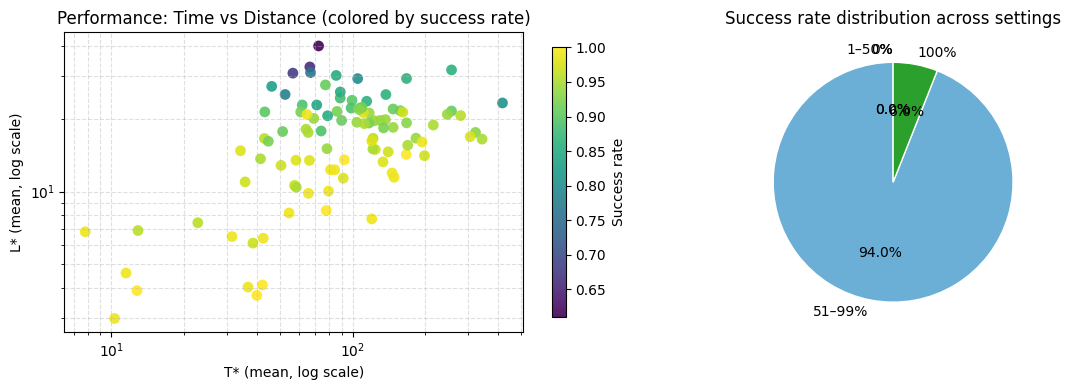

In [ ]:
# @title
import matplotlib.cm as cm

# --- improved scatter plot for T* vs L* ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Compute a color by success rate for clarity
colors = df_agg["success_rate"].clip(0, 1)  # ensure within [0,1]
cmap = cm.get_cmap("viridis")

# --- Left plot: T* vs L* (log-log, colored by success rate) ---
sc = axes[0].scatter(
    df_agg["T_star_mean"],
    df_agg["L_star_mean"],
    c=colors,
    cmap=cmap,
    s=60,
    alpha=0.9,
    edgecolor="none"
)
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("T* (mean, log scale)")
axes[0].set_ylabel("L* (mean, log scale)")
axes[0].set_title("Performance: Time vs Distance (colored by success rate)")
cb = fig.colorbar(sc, ax=axes[0], label="Success rate", shrink=0.9)
axes[0].grid(True, which="both", ls="--", alpha=0.4)

# --- Right plot: success rate pie chart ---
success_counts = (
    pd.cut(df_agg["success_rate"], bins=[-0.001, 0.0, 0.5, 0.99, 1.001],
           labels=["0%", "1–50%", "51–99%", "100%"])
    .value_counts()
    .sort_index()
)

axes[1].pie(
    success_counts,
    labels=success_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#d62728", "#ffb347", "#6baed6", "#2ca02c"],
    wedgeprops={"edgecolor": "white"}
)
axes[1].set_title("Success rate distribution across settings")

plt.tight_layout()
plt.show()


## Pareto Front & Visualization

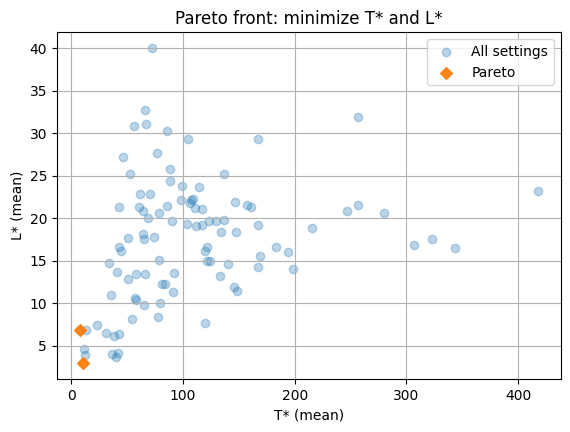

In [ ]:
# @title
# Cell 4: Pareto front (minimize both T* and L*)

def pareto_front(df: pd.DataFrame, xcol="T_star_mean", ycol="L_star_mean"):
    X = df[[xcol, ycol]].to_numpy()
    n = len(X)
    dominated = np.zeros(n, dtype=bool)
    for i in range(n):
        if dominated[i]:
            continue
        xi, yi = X[i]
        for j in range(n):
            if i == j:
                continue
            xj, yj = X[j]
            # j dominates i if no worse in both and strictly better in at least one
            if (xj <= xi and yj <= yi) and (xj < xi or yj < yi):
                dominated[i] = True
                break
    return df.loc[~dominated].copy()

df_pareto = pareto_front(df_agg, "T_star_mean", "L_star_mean")

# visualize
plt.figure(figsize=(6.5, 4.5))
plt.scatter(df_agg["T_star_mean"], df_agg["L_star_mean"], alpha=0.3, label="All settings")
plt.scatter(df_pareto["T_star_mean"], df_pareto["L_star_mean"], alpha=0.95, label="Pareto", marker="D")
plt.xlabel("T* (mean)")
plt.ylabel("L* (mean)")
plt.title("Pareto front: minimize T* and L*")
plt.legend()
plt.show()

## Rank Knob Importance

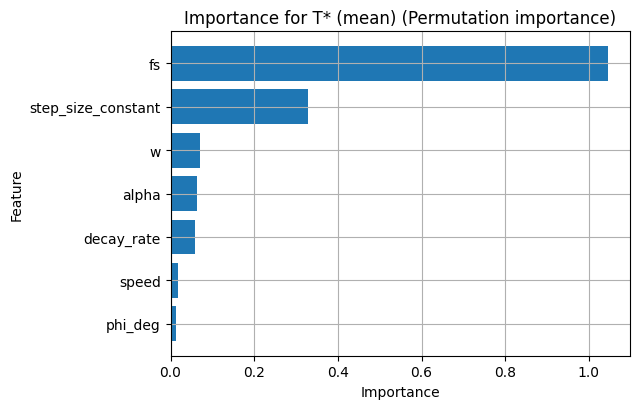

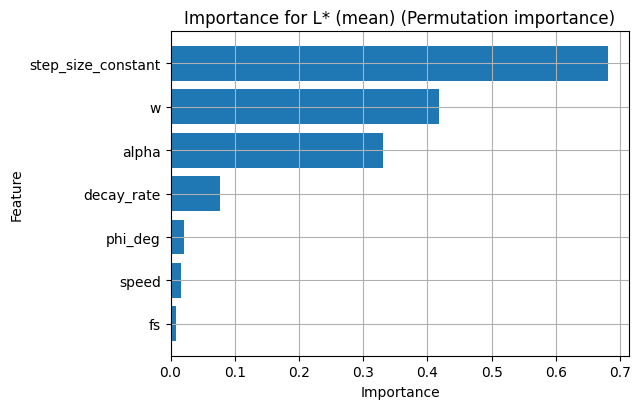

(              feature  rf_importance  perm_importance
 5                  fs       0.544998         1.046015
 6  step_size_constant       0.212699         0.327826
 2                   w       0.060194         0.070438
 3               alpha       0.059624         0.063624
 4          decay_rate       0.064173         0.059509
 0               speed       0.032161         0.018824
 1             phi_deg       0.026150         0.013626,
               feature  rf_importance  perm_importance
 6  step_size_constant       0.423188         0.680589
 2                   w       0.224036         0.418498
 3               alpha       0.202449         0.330576
 4          decay_rate       0.071301         0.076408
 1             phi_deg       0.031262         0.021659
 0               speed       0.027593         0.015682
 5                  fs       0.020173         0.008341)

In [ ]:
# @title
# Cell 5: Feature importance for T* and L* using Random Forest + permutation importance

FEATURES = list(PARAM_RANGES.keys())

def rank_importance(df, target_col):
    X = df[FEATURES].copy()
    y = df[target_col].values
    # some features range widely; random forest is OK without scaling,
    # but permutation importance is more stable if we standardize targets only
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X, y)
    pi = permutation_importance(rf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    imp_df = pd.DataFrame({
        "feature": FEATURES,
        "rf_importance": rf.feature_importances_,
        "perm_importance": pi.importances_mean
    }).sort_values("perm_importance", ascending=False)
    return imp_df, rf

imp_T, _ = rank_importance(df_agg, "T_star_mean")
imp_L, _ = rank_importance(df_agg, "L_star_mean")

# Plot
def plot_importance(imp_df, title):
    plt.figure(figsize=(6.5, 4.2))
    order = imp_df.sort_values("perm_importance", ascending=True)
    plt.barh(order["feature"], order["perm_importance"])
    plt.title(title + " (Permutation importance)")
    plt.xlabel("Importance"); plt.ylabel("Feature")
    plt.tight_layout(); plt.show()

plot_importance(imp_T, "Importance for T* (mean)")
plot_importance(imp_L, "Importance for L* (mean)")

imp_T, imp_L

## Best Combinations

In [ ]:
# @title

# Normalize objectives for a fair sum
obj = df_pareto[["T_star_mean","L_star_mean"]].to_numpy()
mins = obj.min(axis=0); maxs = obj.max(axis=0)
rng = np.where((maxs - mins) == 0, 1.0, (maxs - mins))
norm = (obj - mins) / rng
score = norm.sum(axis=1)  # equal weights

df_pareto_scored = df_pareto.copy()
df_pareto_scored["score_sum_norm"] = score

# Add a robustness tiebreak: combine CVaR too (scaled)
cvars = df_pareto_scored[["T_star_cvar","L_star_cvar"]].to_numpy()
mins2 = cvars.min(axis=0); maxs2 = cvars.max(axis=0)
rng2  = np.where((maxs2 - mins2) == 0, 1.0, (maxs2 - mins2))
cvn   = (cvars - mins2) / rng2
df_pareto_scored["score_sum_norm_robust"] = df_pareto_scored["score_sum_norm"] + 0.5 * cvn.sum(axis=1)

# Top K
TOP_K = 10
winners_simple = df_pareto_scored.sort_values("score_sum_norm").head(TOP_K)
winners_robust = df_pareto_scored.sort_values("score_sum_norm_robust").head(TOP_K)

# Select best rows (first entries)
best_eq  = winners_simple.iloc[0]
best_rob = winners_robust.iloc[0]

# Combine into one comparison DataFrame
comparison_rows = []

def _fmt(x):
    return f"{x:.4f}" if isinstance(x, (int, float, np.floating)) else str(x)

for col in ["T_star_mean","L_star_mean","success_rate","T_star_cvar","L_star_cvar"] + FEATURES:
    val_eq  = best_eq.get(col, np.nan)
    val_rob = best_rob.get(col, np.nan)
    comparison_rows.append({
        "Parameter": col,
        "Top Equal-Weight": _fmt(val_eq),
        "Top Robust": _fmt(val_rob)
    })

comparison_df = pd.DataFrame(comparison_rows)

print("=== Comparison: Top Equal-Weight vs Top Robust Winners ===")
display(comparison_df)

=== Comparison: Top Equal-Weight vs Top Robust Winners ===


,Parameter,Top Equal-Weight,Top Robust
0,T_star_mean,10.3055,10.3055
1,L_star_mean,2.9852,2.9852
2,success_rate,0.9900,0.9900
3,T_star_cvar,58.8963,58.8963
4,L_star_cvar,13.3915,13.3915
5,speed,2.0650,2.0650
6,phi_deg,84.7940,84.7940
7,w,14.0000,14.0000
8,alpha,0.1416,0.1416
9,decay_rate,6.1673,6.1673


# Robustness Test

In [ ]:
ENV_RANGES = {
    "P0": (-60.0, -20.0),
    "n": (1.2, 2.4),
    "d0": (1.0, 1.0),                # fixed (kept for completeness)
    "sigma_min": (2.0, 5.0),
    "sigma_max": (4.0, 10.0),
    "sigma_max_dist": (50.0, 150.0),
    "target_rssi_dbm": (-55.0, -45.0),
    "rssi_floor_dbm": (-110.0, -90.0),
}

def sample_env_lhs(n_samples, ranges, seed=2026):
    keys = list(ranges.keys())
    var_keys = [k for k,(lo,hi) in ranges.items() if hi - lo > 1e-9]
    fix_keys = [k for k,(lo,hi) in ranges.items() if hi - lo <= 1e-9]

    lows  = np.array([ranges[k][0] for k in var_keys], dtype=float)
    highs = np.array([ranges[k][1] for k in var_keys], dtype=float)

    sampler = qmc.LatinHypercube(d=len(var_keys), seed=seed)
    U = sampler.random(n=n_samples)
    X = qmc.scale(U, lows, highs)

    df = pd.DataFrame(X, columns=var_keys)
    for k in fix_keys:  # put fixed columns back
        df[k] = ranges[k][0]
    return df[keys]


In [ ]:
def test_robustness(params: AlgoParams,
                    env_df: pd.DataFrame,
                    start_range=(100.0, 200.0),
                    home_xy=(0.0, 0.0),
                    max_steps=5000,
                    reps_per_env=1,
                    base_seed=999):
    rows = []
    rng = np.random.default_rng(base_seed)
    for i, row in env_df.iterrows():
        env = EnvModel(**{k: float(row[k]) for k in ENV_RANGES})
        theta = rng.uniform(0, 2*math.pi)
        dist = rng.uniform(start_range[0], start_range[1])
        # average over reps_per_env different noise draws
        start_xy = (home_xy[0] + dist * math.cos(theta),
                        home_xy[1] + dist * math.sin(theta))

        success_count = 0
        metrics = []
        for r in range(reps_per_env):
            out = simulate_run(env, params, start_xy=start_xy, home_xy=home_xy,
                               max_steps=max_steps, rng_seed=base_seed + 1000*i + r)
            success_count += int(out["success"])
            metrics.append(out)
        success_rate = success_count / reps_per_env
        # store mean metrics across reps
        mean_T = float(np.mean([m["T"] for m in metrics]))
        mean_L = float(np.mean([m["L"] for m in metrics]))
        mean_Ts = float(np.mean([m["T_star"] for m in metrics]))
        mean_Ls = float(np.mean([m["L_star"] for m in metrics]))
        rows.append({**row.to_dict(),
                     "success_rate": success_rate,
                     "T": mean_T, "L": mean_L, "T_star": mean_Ts, "L_star": mean_Ls})
    return pd.DataFrame(rows)

In [ ]:
best_params = AlgoParams(
    speed=1,
    phi_deg=84.7940,
    w=14,
    alpha=0.1416,
    decay_rate=6.1673,
    fs=4.1237,
    step_size_constant=6.1168,
    min_step_size=0.4
)

# ---------- Run it ----------
N_SAMPLES = 100         # number of environments
REPS_PER_ENV = 10        # >1 to average out measurement noise per env
env_samples = sample_env_lhs(N_SAMPLES, ENV_RANGES, seed=2026)
results = test_robustness(best_params, env_samples,
                          max_steps=5000, reps_per_env=REPS_PER_ENV, base_seed=999)


Success rate over 10 envs (threshold 0.5 over 5 reps): 0.800  (8 success / 2 fail)


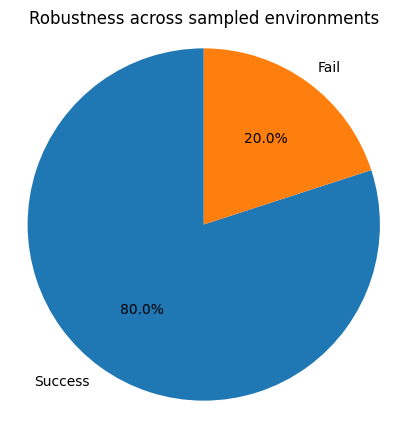

In [ ]:
# Success = success_rate >= 0.5 (majority of reps). Tweak threshold if you like.
success_bool = results["success_rate"] >= 0.5
succ_rate = float(success_bool.mean())
n_succ = int(success_bool.sum())
n_fail = int(len(results) - n_succ)
print(f"Success rate over {N_SAMPLES} envs (threshold 0.5 over {REPS_PER_ENV} reps): "
      f"{succ_rate:.3f}  ({n_succ} success / {n_fail} fail)")

# Pie chart
plt.figure(figsize=(5,5))
plt.pie([n_succ, n_fail], labels=["Success","Fail"], autopct="%1.1f%%", startangle=90)
plt.title("Robustness across sampled environments")
plt.axis("equal")
plt.show()



In [ ]:

# Ensure results DataFrame exists (from previous test)
assert 'results' in globals(), "Run the robustness test cell first!"

T_vals = results["T"].to_numpy()
L_vals = results["L"].to_numpy()

def summarize_metric(name, data):
    data = np.array(data, dtype=float)
    mean = np.mean(data)
    std  = np.std(data, ddof=1)

    print(f"--- {name} ---")
    print(f"Mean ± SD: {mean:.3f} ± {std:.3f}")

    return dict(mean=mean, std=std)

summary_T = summarize_metric("Total Time (T)", T_vals)
summary_L = summarize_metric("Distance (L)", L_vals)

# --- Visualization ---

datasets = [T_vals, L_vals]
summaries = [summary_T, summary_L]


# --- Summary table (for research use) ---
summary_df = pd.DataFrame([
    {"Metric": "Total Time (T)", **summary_T},
    {"Metric": "Distance (L)", **summary_L}
])
display(summary_df)




--- Total Time (T) ---
Mean ± SD: 6347.413 ± 7536.216
--- Distance (L) ---
Mean ± SD: 1288.714 ± 1198.084


,Metric,mean,std
0,Total Time (T),6347.413364,7536.215687
1,Distance (L),1288.713653,1198.084287


## Time Constraints Test

In [ ]:


def test_start_distance_ranges(
    params: AlgoParams,
    env: EnvModel,
    distance_ranges, # list of (min_dist, max_dist) tuples
    n_tests_per_range=100,
    max_steps=5000,
    max_total_time_sec=60, # 10 minutes
    base_seed=456
):
    all_results = []
    rng = np.random.default_rng(base_seed)
    home_xy = (0.0, 0.0)
    for min_dist, max_dist in distance_ranges:
        range_results = []
        print(f"Testing distance range: {min_dist}m - {max_dist}m")
        for i in range(n_tests_per_range):


            # Sample start point within the distance range
            r = rng.uniform(min_dist, max_dist)
            theta = rng.uniform(0, 2 * np.pi)
            start_x = r * math.cos(theta)
            start_y = r * math.sin(theta)
            start_xy = (start_x, start_y)

            out = simulate_run(
                env,
                params,
                start_xy=start_xy,
                home_xy=home_xy,
                max_steps=max_steps,
                rng_seed=rng.integers(1, 1_000_000)
            )
            simulation_time = out["T"]
            finished_in_time = simulation_time <= max_total_time_sec
            range_results.append({
                "min_dist": min_dist,
                "max_dist": max_dist,
                "start_dist": math.hypot(start_x, start_y),
                "success": out["success"] and finished_in_time,  # Success means both reached home AND finished in time
                "simulation_time": simulation_time,
                "finished_in_time": finished_in_time,
                "reached_home": out["success"],
                "steps": out["steps"],
                "L": out["L"],
                "final_dist": math.hypot(out["path"][-1][0], out["path"][-1][1]),
                "final_rssi": out["rssi"][-1] if len(out["rssi"]) > 0 else np.nan
            })
        all_results.extend(range_results)
    return pd.DataFrame(all_results)

# Use the best parameters found previously (from best_rob or best_eq)
# Assuming best_rob is available from the previous execution
best_params = AlgoParams(
    speed=1,
    phi_deg=84.7940,
    w=14,
    alpha=0.1416,
    decay_rate=6.1673,
    fs=4.1237,
    step_size_constant=6.1168,
    min_step_size=0.4
)


# Define distance ranges
distance_ranges = [
    (50, 100),
    (100, 200),
    (200, 300),
    (300, 400),
    (400, 500),
    (500, 1000)
]

# Use the default environment model
env_default = EnvModel()

# Run the test
start_distance_results = test_start_distance_ranges(
    best_params_test,
    env_default,
    distance_ranges,
    n_tests_per_range=1000, # Number of tests per distance range
    max_total_time_sec=600 # 10 minutes time limit
)

Testing distance range: 50m - 100m
Testing distance range: 100m - 200m
Testing distance range: 200m - 300m
Testing distance range: 300m - 400m
Testing distance range: 400m - 500m
Testing distance range: 500m - 1000m


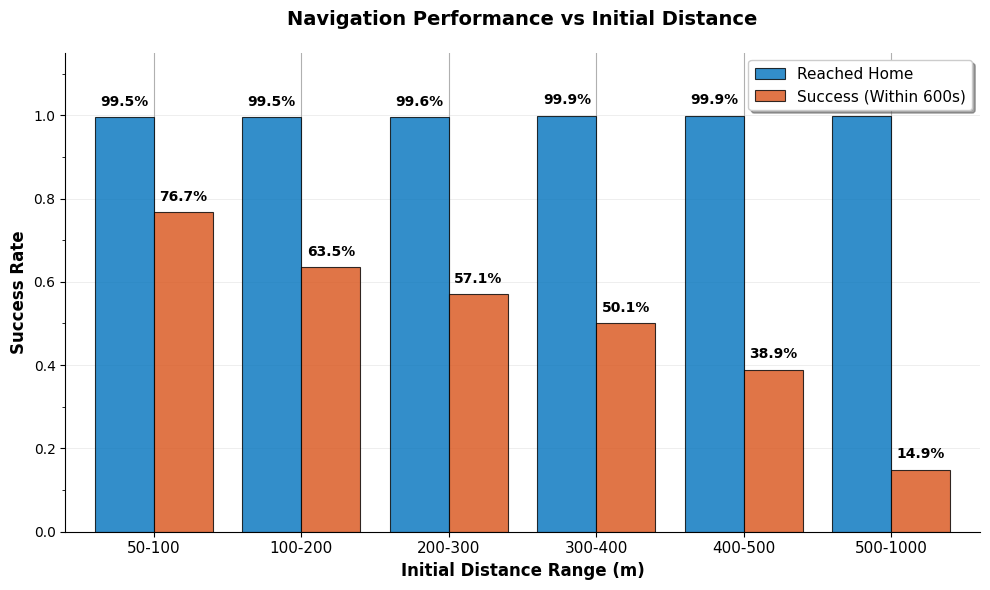


NAVIGATION PERFORMANCE SUMMARY
Distance Range  Reached Home Success (<600s) Timeout Rate
------------------------------------------------------------
50-100          995/1000 ( 99.5%)  767/1000 ( 76.7%)     22.8%
100-200         995/1000 ( 99.5%)  635/1000 ( 63.5%)     36.0%
200-300         996/1000 ( 99.6%)  571/1000 ( 57.1%)     42.5%
300-400         999/1000 ( 99.9%)  501/1000 ( 50.1%)     49.8%
400-500         999/1000 ( 99.9%)  389/1000 ( 38.9%)     61.0%
500-1000        999/1000 ( 99.9%)  149/1000 ( 14.9%)     85.0%
------------------------------------------------------------
OVERALL          99.7%           50.2%             49.5%


In [ ]:
#  Calculate rates for each distance range
rates = start_distance_results.groupby(['min_dist', 'max_dist']).agg({
    'success': 'mean',  # Reached home AND finished in time
    'reached_home': 'mean'  # Just reached home regardless of time
}).reset_index()
rates['range'] = rates.apply(lambda x: f"{int(x['min_dist'])}-{int(x['max_dist'])}", axis=1)

# Create the bar plot with MATLAB style
plt.figure(figsize=(10, 6))

# Use MATLAB-like colors
matlab_blue = '#0072BD'
matlab_red = '#D95319'

x = np.arange(len(rates['range']))
width = 0.4  # Slightly wider bars

# Create bars with MATLAB style
bars1 = plt.bar(x - width/2, rates['reached_home'], width,
                label='Reached Home',
                color=matlab_blue,
                edgecolor='black',
                linewidth=0.8,
                alpha=0.8)

bars2 = plt.bar(x + width/2, rates['success'], width,
                label='Success (Within 600s)',
                color=matlab_red,
                edgecolor='black',
                linewidth=0.8,
                alpha=0.8)

# Add value labels on top of bars with better formatting
for bar, rate in zip(bars1, rates['reached_home']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{rate:.1%}', ha='center', va='bottom',
             fontsize=10, fontweight='bold')

for bar, rate in zip(bars2, rates['success']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{rate:.1%}', ha='center', va='bottom',
             fontsize=10, fontweight='bold')

# MATLAB-style customization
plt.title('Navigation Performance vs Initial Distance',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Initial Distance Range (m)', fontsize=12, fontweight='bold')
plt.ylabel('Success Rate', fontsize=12, fontweight='bold')
plt.ylim(0, 1.15)

# MATLAB-style grid
plt.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
plt.gca().set_axisbelow(True)  # Grid behind bars

# X-axis formatting
plt.xticks(x, rates['range'], fontsize=11)
plt.xlim(-0.6, len(rates['range'])-0.4)

# Legend with MATLAB style
plt.legend(loc='upper right', frameon=True, fancybox=True,
           shadow=True, fontsize=11)

# Remove spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add minor ticks
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.1))

plt.tight_layout()
plt.show()

# Print detailed statistics in a clean format
print("\n" + "="*60)
print("NAVIGATION PERFORMANCE SUMMARY")
print("="*60)
print(f"{'Distance Range':<15} {'Reached Home':<12} {'Success (<600s)':<15} {'Timeout Rate':<12}")
print("-"*60)

for _, row in rates.iterrows():
    total_in_range = len(start_distance_results[
        (start_distance_results['min_dist'] == row['min_dist']) &
        (start_distance_results['max_dist'] == row['max_dist'])
    ])
    reached_home_count = int(row['reached_home'] * total_in_range)
    success_count = int(row['success'] * total_in_range)
    timeout_rate = row['reached_home'] - row['success']

    print(f"{row['range']:<15} {reached_home_count:>2d}/{total_in_range:<2} ({row['reached_home']:>6.1%})  "
          f"{success_count:>2d}/{total_in_range:<2} ({row['success']:>6.1%})    "
          f"{timeout_rate:>6.1%}")

print("-"*60)
overall_reached = start_distance_results['reached_home'].mean()
overall_success = start_distance_results['success'].mean()
print(f"{'OVERALL':<15} {overall_reached:>6.1%}          {overall_success:>6.1%}            {overall_reached - overall_success:>6.1%}")